In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

#scikit learn  library
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
#Use LogisticRegression for classifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#oversampling
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir("inputs"))

# Any results you write to the current directory are saved as output.

C:\Users\OnielG\AppData\Local\Continuum\anaconda3\envs\python36\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


_pywrap_tensorflow_internal
['sample_submission.csv', 'test.csv', 'train.csv']


In [144]:
# Read data
train = pd.read_csv('inputs/train.csv')
test = pd.read_csv('inputs/test.csv')
sample_sub  = pd.read_csv('inputs/sample_submission.csv') 

In [145]:
def extract_product(str):
    if ";"  in str:
        prd_lst = str.split(";")
        count_item = len(prd_lst)
        first_lv1 = prd_lst[0].split("/")[0]
        first_lv2 = prd_lst[0].split("/")[1]
        first_lv3 = prd_lst[0].split("/")[2]
        first_lv4 = prd_lst[0].split("/")[3]
        
        lv1_lst =[]
        lv2_lst =[]
        lv3_lst =[]
        lv4_lst =[]
        for item in prd_lst:
            lv1_lst.append(item.split("/")[0])
            lv2_lst.append(item.split("/")[1])
            lv3_lst.append(item.split("/")[2])
            lv4_lst.append(item.split("/")[3])
            
        unique_lv1 = len(set(lv1_lst))
        unique_lv2 = len(set(lv2_lst))
        unique_lv3 = len(set(lv2_lst))
        unique_lv4 = len(set(lv2_lst))
        most_freq_lv1 =  max(lv1_lst, key=Counter(lv1_lst).get)        
    else:
        lv_lst = str.split("/")
        first_lv1 = lv_lst[0]
        first_lv2 = lv_lst[1]
        first_lv3 = lv_lst[2]
        first_lv4 = lv_lst[3]
        
        count_item = 1
        unique_lv1 = 1
        unique_lv2 = 1
        unique_lv3 = 1
        unique_lv4 = 1
        
        most_freq_lv1 = first_lv1
    return (count_item,first_lv1,first_lv2,first_lv3,first_lv4,unique_lv1,unique_lv2,unique_lv3,unique_lv4,most_freq_lv1)    

In [146]:
#fullproductlist = pd.concat([train['ProductList'], test['ProductList']]) 

In [147]:
#fullproductlist.shape

In [148]:
#new_col_lst = fullproductlist.apply(lambda x: extract_product(x))  

In [149]:
#Feature Extraction :
new_col = ('NumProduct','FirstA','FirstB','FirstC','FirstD','UniqueA','UniqueB','UniqueC','UniqueD','MostA')      
#new_col_lst = fullproductlist.apply(lambda x: extract_product(x))    

new_col_lst = train['ProductList'].apply(lambda x: extract_product(x))    
new_col_df = pd.DataFrame(new_col_lst.tolist(),columns =new_col)
train = pd.concat([train, new_col_df], axis=1)

new_col_lst = None
new_col_df = None

new_col_lst = test['ProductList'].apply(lambda x: extract_product(x))    
new_col_df = pd.DataFrame(new_col_lst.tolist(),columns =new_col)
test = pd.concat([test, new_col_df], axis=1)

In [150]:
train.shape,test.shape

((10500, 15), (4500, 14))

In [151]:
#list(train.isnull().any())

In [154]:
# Time feature extraction
train['startTime'] = pd.to_datetime(train['startTime'])
train['endTime'] = pd.to_datetime(train['endTime'])
train['duration'] = train['endTime'] - train['startTime']
train['duration'] = train['duration'].astype('timedelta64[m]')
train['weekday'] = train['startTime'].dt.dayofweek
train['hour_24h'] = train['startTime'].dt.hour

#Date Features
train['day'] = train['startTime'].dt.day
train['weekend'] = (train['startTime'].dt.weekday >=5).astype(int)

In [156]:
test['startTime'] = pd.to_datetime(test['startTime'])
test['endTime'] = pd.to_datetime(test['endTime'])
test['duration'] = test['endTime'] - test['startTime']
test['duration'] = test['duration'].astype('timedelta64[m]')
test['weekday'] = test['startTime'].dt.dayofweek
test['hour_24h'] = test['startTime'].dt.hour

#Date Features
test['day'] = test['startTime'].dt.day
test['weekend'] = (test['startTime'].dt.weekday >=5).astype(int)

In [157]:
drop_lst = ['session_id', 'startTime', 'endTime', 'ProductList']
#train = train.drop(drop_lst,axis =1 )
#test = test.drop(drop_lst,axis =1 )
#print(data.head())

In [158]:
train['gender'] = train['gender'].map({'female':1,'male':0})

<Figure size 864x432 with 0 Axes>

(array([0, 1]), <a list of 2 Text xticklabel objects>)

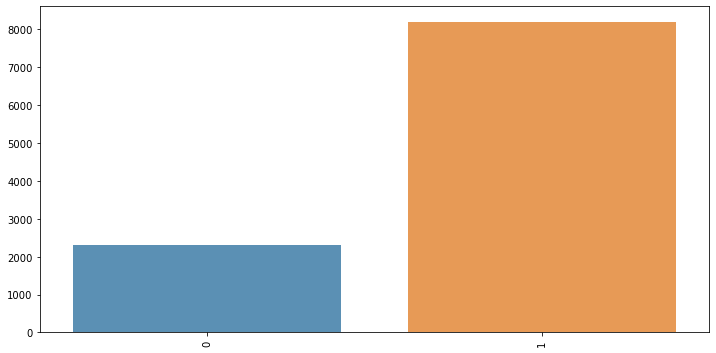

In [159]:
cnt_srs = train.gender.value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xticks(rotation='vertical')
plt.show()

In [160]:
# drop_lst = ['session_id', 'startTime', 'endTime', 'ProductList']
# X_train = train.drop(drop_lst,axis =1 )
# Y_train = train['gender']
# X_train = X_train.drop('gender',axis = 1)
    
# X_test =  test.drop(drop_lst,axis =1 )


In [161]:
## Regularized Expanding mean scheme
for features in ['FirstA','FirstB','FirstC', 'FirstD', 'MostA']:
    cumsum = train.groupby(features)['gender'].cumsum() - train['gender']
    cumcnt = train.groupby(features).cumcount()
    train[features + 'meantarget'] = cumsum/cumcnt
    test[features + 'meantarget'] = cumsum/cumcnt

In [162]:
drop_lst = ['session_id', 'startTime', 'endTime', 'ProductList']
data = pd.concat([train, test])
data = data.drop(drop_lst,axis =1 )

In [163]:
data.shape

(15000, 21)

In [192]:
train.columns

Index(['session_id', 'startTime', 'endTime', 'ProductList', 'gender',
       'NumProduct', 'FirstA', 'FirstB', 'FirstC', 'FirstD', 'UniqueA',
       'UniqueB', 'UniqueC', 'UniqueD', 'MostA', 'duration', 'weekday',
       'hour_24h', 'day', 'weekend', 'FirstAmeantarget', 'FirstBmeantarget',
       'FirstCmeantarget', 'FirstDmeantarget', 'MostAmeantarget'],
      dtype='object')

In [199]:
data.weekend

0       0
1       0
2       1
3       1
4       0
       ..
4495    0
4496    0
4497    1
4498    0
4499    0
Name: weekend, Length: 15000, dtype: int32

In [164]:
data = pd.get_dummies(data)

In [226]:
drop_lst = ['day', 'weekend','FirstAmeantarget', 'FirstBmeantarget','FirstCmeantarget', 'FirstDmeantarget', 'MostAmeantarget']

X_train = data.loc[data.gender.isnull() == False].drop(drop_lst,axis =1 )
Y_train = train['gender']
X_train = X_train.drop('gender',axis = 1)

X_test =  data.loc[data.gender.isnull()] .drop(drop_lst,axis =1 )
X_test = X_test.drop('gender',axis = 1)

In [227]:
#len(data.loc[data.gender.isnull() == False])

In [228]:
#Encoding for categories features
#X_train = pd.get_dummies(X_train)
#X_test = pd.get_dummies(X_test)

In [229]:
#list(train.isnull().any())
#train.head()
#list(train.isnull().any())

X_train= X_train.fillna(0)
X_test = X_test.fillna(0)

In [241]:
val_size = 0.25
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=val_size)

print(X_train.shape)
print(X_val.shape)

(7140, 11548)
(1785, 11548)


In [242]:
clf = RandomForestClassifier(class_weight = {1:.1, 0:.35})
clf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.35, 1: 0.1}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [243]:
print("Evalute based on validation set")

print("f1 : " + " %s" % f1_score(Y_val, clf.predict(X_val)))

print("accuracy score" + " %s" % accuracy_score(Y_val, clf.predict(X_val)))
print("recall score micro: " + " %s" % recall_score(Y_val, clf.predict(X_val), average='micro'))
print("recall score macro: " + " %s" % recall_score(Y_val, clf.predict(X_val), average='macro'))

Evalute based on validation set
f1 :  0.9280055115397865
accuracy score 0.8829131652661064
recall score micro:  0.8829131652661064
recall score macro:  0.7767943297412365


In [244]:
X_test.shape,X_train.shape

((4500, 11548), (7140, 11548))

In [245]:
predresults = clf.predict(X_test)

In [246]:
results = pd.DataFrame(data=predresults, columns=["gender"])
results['gender'] = results['gender'].map({1:'female',0:'male'})
sample_sub['gender'] = results['gender']
sample_sub.to_csv('sample_submission_11th_April_1.2.csv',index=False)

In [247]:
sample_sub.shape,results.shape

((4500, 2), (4500, 1))

In [248]:
# Logistic Regression

In [251]:
drop_lst = ['day', 'weekend','FirstAmeantarget', 'FirstBmeantarget','FirstCmeantarget', 'FirstDmeantarget', 'MostAmeantarget']

X_train = data.loc[data.gender.isnull() == False].drop(drop_lst,axis =1 )
Y_train = train['gender']
X_train = X_train.drop('gender',axis = 1)

X_test =  data.loc[data.gender.isnull()] .drop(drop_lst,axis =1 )
X_test = X_test.drop('gender',axis = 1)
X_train= X_train.fillna(0)
X_test = X_test.fillna(0)

In [252]:
# Logistic Regression

i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 

for train_index,test_index in kf.split(X_train,Y_train):     
    print('\n{} of kfold {}'.format(i,kf.n_splits))   

    xtr,xvl = X_train.loc[train_index],X_train.loc[test_index]     
    ytr,yvl = Y_train[train_index],Y_train[test_index]         

    model = LogisticRegression(random_state=1)     
    model.fit(xtr, ytr)     
    pred_test = model.predict(xvl)     
    score = accuracy_score(yvl,pred_test)     
    print('accuracy_score',score)     
    i+=1 

pred_test = model.predict(X_test) 
pred=model.predict_proba(xvl)[:,1]


1 of kfold 5


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

accuracy_score 0.8623809523809524

2 of kfold 5


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

accuracy_score 0.86

3 of kfold 5


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

accuracy_score 0.8633333333333333

4 of kfold 5


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

accuracy_score 0.8809523809523809

5 of kfold 5


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

accuracy_score 0.8595238095238096


In [253]:
results = pd.DataFrame(data=pred_test, columns=["gender"])
results['gender'] = results['gender'].map({1:'female',0:'male'})
sample_sub['gender'] = results['gender']
sample_sub.to_csv('sample_submission_11th_April_2.csv',index=False)

In [254]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [261]:
num_leafs = [1, 5, 10]
depths = [3, 5, 10] #np.arange(1, 20)
min_split = [3, 5, 10] #np.arange(1, 10)

param_grid = [{'max_depth':depths,
              'min_samples_leaf':num_leafs,
              'min_samples_split':min_split}]

model = DecisionTreeClassifier(random_state=1)   

gs = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=10)
gs = gs.fit(X_train, Y_train)

print(gs.best_score_)
print(gs.best_params_)

0.8726666666666667
{'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 3}


In [263]:
i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 


for train_index,test_index in kf.split(X_train,Y_train):     
    print('\n{} of kfold {}'.format(i,kf.n_splits))   

    xtr,xvl = X_train.loc[train_index],X_train.loc[test_index]     
    ytr,yvl = Y_train[train_index],Y_train[test_index]        
    
    model = DecisionTreeClassifier(random_state=1,max_depth =  5,min_samples_leaf=10, min_samples_split=3)     
    model.fit(xtr, ytr)     
    pred_test = model.predict(xvl)     
    score = accuracy_score(yvl,pred_test)     
    print('accuracy_score',score)     
    i+=1 
pred_test = model.predict(X_test)


1 of kfold 5


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

accuracy_score 0.8642857142857143

2 of kfold 5


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

accuracy_score 0.8661904761904762

3 of kfold 5


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

accuracy_score 0.8685714285714285

4 of kfold 5


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

accuracy_score 0.8833333333333333

5 of kfold 5


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

accuracy_score 0.8666666666666667


In [264]:
results = pd.DataFrame(data=pred_test, columns=["gender"])
results['gender'] = results['gender'].map({1:'female',0:'male'})
sample_sub['gender'] = results['gender']
sample_sub.to_csv('sample_submission_11th_April_DT.csv',index=False)

In [265]:
i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X_train,Y_train):     
    print('\n{} of kfold {}'.format(i,kf.n_splits))   

    xtr,xvl = X_train.loc[train_index],X_train.loc[test_index]     
    ytr,yvl = Y_train[train_index],Y_train[test_index]        
    
    model = RandomForestClassifier(random_state=1, max_depth=15, n_estimators=500,class_weight = {1:.1, 0:.35})
    #,
    model.fit(xtr, ytr)     
    pred_test = model.predict(xvl)     
    score = accuracy_score(yvl,pred_test)     
    print('accuracy_score',score)     
    i+=1 

pred_test = model.predict(X_test) 
#pred2=model.predict_proba(test)[:,1]


1 of kfold 5


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.35, 1: 0.1}, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)

accuracy_score 0.8609523809523809

2 of kfold 5


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.35, 1: 0.1}, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)

accuracy_score 0.8652380952380953

3 of kfold 5


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.35, 1: 0.1}, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)

accuracy_score 0.8642857142857143

4 of kfold 5


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.35, 1: 0.1}, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)

accuracy_score 0.8795238095238095

5 of kfold 5


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.35, 1: 0.1}, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)

accuracy_score 0.8652380952380953


In [111]:
results = pd.DataFrame(data=pred_test, columns=["gender"])
results['gender'] = results['gender'].map({1:'female',0:'male'})
sample_sub['gender'] = results['gender']
sample_sub.to_csv('sample_submission_11th_April_3.csv',index=False)

In [116]:
def CreateBalancedSampleWeights(y_train, largest_class_weight_coef):
    classes = np.unique(y_train, axis = 0)
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in y_train]
    return sample_weights

In [118]:
largest_class_weight_coef = max(train['gender'].value_counts().values)/Y_train.shape[0]

#pass y_train as numpy array
weight = CreateBalancedSampleWeights(Y_train, largest_class_weight_coef)


In [124]:
#'scale_pos_weight'] = sum_wneg/sum_wpos
train['gender'].value_counts()
train['gender'].value_counts()[0]
train['gender'].value_counts()[1]
scale_pos_weight = train['gender'].value_counts()[0]/ train['gender'].value_counts()[1]
scale_pos_weight

1    8192
0    2308
Name: gender, dtype: int64

2308

8192

0.28173828125

In [119]:
from xgboost import XGBClassifier
i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X_train,Y_train):     
    print('\n{} of kfold {}'.format(i,kf.n_splits))   

    xtr,xvl = X_train.loc[train_index],X_train.loc[test_index]     
    ytr,yvl = Y_train[train_index],Y_train[test_index]      
    
    model = XGBClassifier(n_estimators=50, max_depth=4,weights = weight,scale_pos_weight=scale_pos_weight)     
    model.fit(xtr, ytr)     
    pred_test = model.predict(xvl)     
    score = accuracy_score(yvl,pred_test)     
    print('accuracy_score',score)     
    i+=1 
pred_test = model.predict(X_test) 



1 of kfold 5


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=None, n_estimators=50,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1,
              weights=[0.5, 2.2746967071057194, 0.5, 0.5, 2.2746967071057194,
                       0.5, 0.5, 2.2746967071057194, 2.2746967071057194, 0.5,
                       0.5, 0.5, 0.5, 2.2746967071057194, 0.5, 0.5, 0.5, 0.5,
                       0.5, 0.5, 2.2746967071057194, 0.5, 2.2746967071057194,
                       0.5, 0.5, 0.5, 2.2746967071057194, 0.5, 0.5,
                       2.2746967071057194, ...])

accuracy_score 0.8642857142857143

2 of kfold 5


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=None, n_estimators=50,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1,
              weights=[0.5, 2.2746967071057194, 0.5, 0.5, 2.2746967071057194,
                       0.5, 0.5, 2.2746967071057194, 2.2746967071057194, 0.5,
                       0.5, 0.5, 0.5, 2.2746967071057194, 0.5, 0.5, 0.5, 0.5,
                       0.5, 0.5, 2.2746967071057194, 0.5, 2.2746967071057194,
                       0.5, 0.5, 0.5, 2.2746967071057194, 0.5, 0.5,
                       2.2746967071057194, ...])

accuracy_score 0.8709523809523809

3 of kfold 5


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=None, n_estimators=50,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1,
              weights=[0.5, 2.2746967071057194, 0.5, 0.5, 2.2746967071057194,
                       0.5, 0.5, 2.2746967071057194, 2.2746967071057194, 0.5,
                       0.5, 0.5, 0.5, 2.2746967071057194, 0.5, 0.5, 0.5, 0.5,
                       0.5, 0.5, 2.2746967071057194, 0.5, 2.2746967071057194,
                       0.5, 0.5, 0.5, 2.2746967071057194, 0.5, 0.5,
                       2.2746967071057194, ...])

accuracy_score 0.8704761904761905

4 of kfold 5


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=None, n_estimators=50,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1,
              weights=[0.5, 2.2746967071057194, 0.5, 0.5, 2.2746967071057194,
                       0.5, 0.5, 2.2746967071057194, 2.2746967071057194, 0.5,
                       0.5, 0.5, 0.5, 2.2746967071057194, 0.5, 0.5, 0.5, 0.5,
                       0.5, 0.5, 2.2746967071057194, 0.5, 2.2746967071057194,
                       0.5, 0.5, 0.5, 2.2746967071057194, 0.5, 0.5,
                       2.2746967071057194, ...])

accuracy_score 0.8838095238095238

5 of kfold 5


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=None, n_estimators=50,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1,
              weights=[0.5, 2.2746967071057194, 0.5, 0.5, 2.2746967071057194,
                       0.5, 0.5, 2.2746967071057194, 2.2746967071057194, 0.5,
                       0.5, 0.5, 0.5, 2.2746967071057194, 0.5, 0.5, 0.5, 0.5,
                       0.5, 0.5, 2.2746967071057194, 0.5, 2.2746967071057194,
                       0.5, 0.5, 0.5, 2.2746967071057194, 0.5, 0.5,
                       2.2746967071057194, ...])

accuracy_score 0.8695238095238095


In [120]:
pred_test = model.predict(X_test) 

In [121]:
results = pd.DataFrame(data=pred_test, columns=["gender"])
results['gender'] = results['gender'].map({1:'female',0:'male'})
sample_sub['gender'] = results['gender']
sample_sub.to_csv('sample_submission_11th_April_5.csv',index=False)

In [140]:
train.columns,X_train.columns
#train['MostA']

(Index(['session_id', 'startTime', 'endTime', 'ProductList', 'gender',
        'NumProduct', 'FirstA', 'FirstB', 'FirstC', 'FirstD', 'UniqueA',
        'UniqueB', 'UniqueC', 'UniqueD', 'MostA', 'duration', 'weekday',
        'hour_24h'],
       dtype='object'),
 Index(['NumProduct', 'UniqueA', 'UniqueB', 'UniqueC', 'UniqueD', 'duration',
        'weekday', 'hour_24h', 'FirstA_A00001', 'FirstA_A00002',
        ...
        'MostA_A00002', 'MostA_A00003', 'MostA_A00004', 'MostA_A00005',
        'MostA_A00006', 'MostA_A00007', 'MostA_A00008', 'MostA_A00009',
        'MostA_A00010', 'MostA_A00011'],
       dtype='object', length=11548))

In [ ]:
# LGBM

In [ ]:
drop_lst = ['day', 'weekend','FirstAmeantarget', 'FirstBmeantarget','FirstCmeantarget', 'FirstDmeantarget', 'MostAmeantarget']

X_train = data.loc[data.gender.isnull() == False].drop(drop_lst,axis =1 )
Y_train = train['gender']
X_train = X_train.drop('gender',axis = 1)

X_test =  data.loc[data.gender.isnull()] .drop(drop_lst,axis =1 )
X_test = X_test.drop('gender',axis = 1)
X_train= X_train.fillna(0)
X_test = X_test.fillna(0)

In [100]:
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold

In [266]:
parameters = {
    'learning_rate': 0.001,
    'application': 'binary',
    'objective': 'binary',
    'metric': 'accuracy',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

In [287]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train,Y_train)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=Y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[val_idx], label=Y_train.iloc[val_idx])
   
    num_round = 10000
    #clf = lgb.LGBMClassifier(parameters, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 100)
    clf = lgb.train(parameters, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(X_train.iloc[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_train.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

#np.sqrt(mean_squared_error(oof, target))
oof = np.where(oof > 0.5, 1, 0)
score = accuracy_score(oof,Y_train)     
print('accuracy_score',score)  
pred_test = np.where(predictions > 0.5, 1, 0)

fold 0
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[127]	training's auc: 0.898724	valid_1's auc: 0.841062
fold 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[297]	training's auc: 0.92218	valid_1's auc: 0.825683
fold 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[148]	training's auc: 0.899568	valid_1's auc: 0.843894
fold 3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[300]	training's auc: 0.920521	valid_1's auc: 0.821462
fold 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[45]	training's auc: 0.871038	valid_1's auc: 0.850384
accuracy_score 0.8434285714285714


In [298]:
score = accuracy_score(oof,Y_train)     
print('accuracy_score',score) 

accuracy_score 0.21980952380952382


In [289]:
results = pd.DataFrame(data=pred_test, columns=["gender"])
results['gender'] = results['gender'].map({1:'female',0:'male'})
sample_sub['gender'] = results['gender']
sample_sub.to_csv('sample_submission_12th_April_6.csv',index=False)

In [290]:
# Repeat K Fold

In [297]:
from sklearn.model_selection import RepeatedKFold
folds = RepeatedKFold(n_splits=5, n_repeats=4, random_state=4520)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
#start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train,Y_train)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=Y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[val_idx], label=Y_train.iloc[val_idx])
   
    num_round = 10000
    clf = lgb.LGBMClassifier(parameters, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 500)
    clf = lgb.train(parameters, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 500)
    oof[val_idx] = clf.predict(X_train.iloc[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_train.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / (5 * 4)

oof = np.where(oof > 0.5, 1, 0)
score = accuracy_score(oof,Y_train)     
print('accuracy_score',score)  
pred_test = np.where(predictions > 0.5, 1, 0)

fold 0
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[251]	training's auc: 0.916157	valid_1's auc: 0.829801
fold 1
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[171]	training's auc: 0.907295	valid_1's auc: 0.838157
fold 2
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[277]	training's auc: 0.917967	valid_1's auc: 0.847921
fold 3
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[134]	training's auc: 0.897484	valid_1's auc: 0.848312
fold 4
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[393]	training's auc: 0.931808	valid_1's auc: 0.825548
fold 5
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[98]	training's auc: 0.888622	valid_1's auc: 0.844801
fold 6
Training until validation scores d

In [299]:
results = pd.DataFrame(data=pred_test, columns=["gender"])
results['gender'] = results['gender'].map({1:'female',0:'male'})
sample_sub['gender'] = results['gender']
sample_sub.to_csv('sample_submission_12th_April_8.csv',index=False)

In [301]:
X_train['gender'] = 1
X_train['gender'] = Y_train

X_train_1 = X_train.loc[X_train.gender == 1]
X_train_0 = X_train.loc[X_train.gender == 0]

In [302]:
X_train_1.shape,X_train_0.shape

((8192, 11549), (2308, 11549))

In [316]:
# Down Sample
from sklearn.utils import resample
n_samples = 100000
X_train_0 = resample(X_train_0,
                                replace = True, 
                                n_samples = n_samples,
                                random_state = 27)

X_train_1 = resample(X_train_1,
                                replace = True,
                                n_samples = n_samples,
                                random_state = 27)

downsampled = pd.concat([X_train_0, X_train_1])
downsampled['gender'].value_counts()

1    100000
0    100000
Name: gender, dtype: int64

In [317]:
downsampled.shape
downsampled_Y = downsampled.gender
downsampled.drop(['gender'],axis = 1,inplace=True)

(200000, 11549)

In [320]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(downsampled_Y))
predictions = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(downsampled,downsampled_Y)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(downsampled.iloc[trn_idx], label=downsampled_Y.iloc[trn_idx])
    val_data = lgb.Dataset(downsampled.iloc[val_idx], label=downsampled_Y.iloc[val_idx])
   
    num_round = 10000
    #clf = lgb.LGBMClassifier(parameters, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 100)
    clf = lgb.train(parameters, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(downsampled.iloc[val_idx], num_iteration=clf.best_iteration)
    
    #fold_importance_df = pd.DataFrame()
    #fold_importance_df["Feature"] = X_train.columns
    #fold_importance_df["importance"] = clf.feature_importance()
    #fold_importance_df["fold"] = fold_ + 1
    #feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

#np.sqrt(mean_squared_error(oof, target))
oof = np.where(oof > 0.5, 1, 0)
score = accuracy_score(oof,downsampled_Y)     
print('accuracy_score',score)  
pred_test = np.where(predictions > 0.5, 1, 0)

fold 0
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[4719]	training's auc: 0.999964	valid_1's auc: 0.999933
fold 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[5634]	training's auc: 0.999987	valid_1's auc: 0.99998
fold 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[6320]	training's auc: 0.999987	valid_1's auc: 0.999981
fold 3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[5339]	training's auc: 0.999981	valid_1's auc: 0.999975
fold 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[3578]	training's auc: 0.999726	valid_1's auc: 0.999552
accuracy_score 0.995505


In [321]:
results = pd.DataFrame(data=pred_test, columns=["gender"])
results['gender'] = results['gender'].map({1:'female',0:'male'})
sample_sub['gender'] = results['gender']
sample_sub.to_csv('sample_submission_12th_April_8.csv',index=False)

In [ ]:
#Finished